<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/12_gan/04_conditional_DC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# conditional DC-GAN
## 目的
条件付きのDC-GANによって意図した画像の生成をして動作を理解する．

## 必要なモジュールのインポート
Pytorchで学習するときに必要となるモジュールをインポートします．

In [1]:
import os
import zipfile
import urllib.request
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

## ネットワークの構築
基本的なネットワーク構造は，DC-GANと同様でConvolution及びDeconvolutionで設計します．
ただ，conditional DC-GANでは条件の入力があるため，Generator及びDiscriminatorの入力層のチャネル数がクラス数分多くなっています．

<img src="https://dl.dropboxusercontent.com/s/42tfm9viymbqemo/cGAN.png" width=50%>



In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, out_ch=3, n_cls=10, img_size=32):
        super(Generator, self).__init__()
        n_layer = int(np.log2(img_size)) - 2
        self.model = nn.Sequential()
        
        features = 512
        self.model.add_module('Deconv_first', nn.ConvTranspose2d(latent_dim+n_cls, features, 2, 2, bias=True))
        self.model.add_module('BN_first', nn.BatchNorm2d(features))
        self.model.add_module('Act_first', nn.ReLU(inplace=True))
  
        in_features = features
        for i in range(n_layer):
            out_features = in_features // 2
            self.model.add_module('Deconv%d' % i, nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=True))
            self.model.add_module('BN%d' % i, nn.BatchNorm2d(out_features))
            self.model.add_module('Act%d' % i, nn.ReLU(inplace=True))
            in_features = out_features
        
        self.model.add_module('Deconv_last', nn.ConvTranspose2d(in_features, out_ch, 2, 2, bias=True))
        self.model.add_module('Act_last', nn.Tanh())
        self.weight_init()

    def weight_init(self):
        for m in self.model:
          if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0.0, 0.02)
            m.bias.data.zero_()

    def forward(self, z):
        return self.model(z)
    
class Discriminator(nn.Module):
    def __init__(self, in_ch=3, n_cls=10, img_size=32):
        super(Discriminator, self).__init__()
        n_layer = int(np.log2(img_size)) - 2
        self.model = nn.Sequential()
        
        features = 32
        self.model.add_module('Conv_first', nn.Conv2d(in_ch+n_cls, features, 4, 2, 1, bias=True))
        self.model.add_module('Act_first', nn.LeakyReLU(negative_slope=0.2))
  
        in_features = features
        for i in range(n_layer):
            out_features = in_features * 2
            self.model.add_module('Conv%d' % i, nn.Conv2d(in_features, out_features, 4, 2, 1, bias=True))
            self.model.add_module('BN%d' % i, nn.BatchNorm2d(out_features))
            self.model.add_module('Act%d' % i, nn.LeakyReLU(negative_slope=0.2))
            in_features = out_features
        
        self.model.add_module('Conv_last', nn.Conv2d(in_features, 1, 2, 1, bias=True))
        self.weight_init()
  
    def weight_init(self):
        for m in self.model:
          if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0.0, 0.02)
            m.bias.data.zero_()

    def forward(self, x):
        return self.model(x).view(-1)

## データセットと最適化関数
データセットにはMNISTを使用します．
最適化関数はAdam optimizer使用し，学習率$2\times 10^4$，betaの値を$0.5, 0.999$として学習します．

In [3]:
class MNIST_Loader(Dataset):
  def __init__(self, train=True, download=True, transform=None):
    self.transform = transform
    self.url = 'https://www.dropbox.com/s/hc7ukm7vzst5e40/MNIST.zip?dl=1'
    
    if download:
      self._download()
    
    dname = os.path.join(self.url.rpartition('/')[2][:-9], 'processed')
    if train:
      datapath = os.path.join(dname, 'training.pt')
    else:
      datapath = os.path.join(dname, 'test.pt')
  
    self.data = torch.load(datapath)

  def __len__(self):
    return len(self.data[0])

  def _download(self):
    filename = self.url.rpartition('/')[2][:-5]
    urllib.request.urlretrieve(self.url, filename)

    with zipfile.ZipFile(filename) as existing_zip:
      existing_zip.extractall()
    os.remove(filename)

  def __getitem__(self, i):
    image = transforms.ToPILImage()(self.data[0][i])
    label = self.data[1][i]

    if self.transform:
      image = self.transform(image)
    return image, label

In [5]:
transform_training = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()])
try:
  mnist_data = datasets.MNIST(root='./data', train=True, transform=transform_training, download=True)
except:
  print('Warning: Switch the original implementation because official MNIST data did not download (probably the official server has down).')
  mnist_data = MNIST_Loader(train=True, download=True, transform=transform_training)
print('Done!') 
training_data = DataLoader(mnist_data, batch_size=100, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 100
cls_num = 10
G = Generator(latent_dim=latent_dim, out_ch=1, n_cls=cls_num, img_size=32).to(device)
D = Discriminator(in_ch=1, n_cls=cls_num, img_size=32).to(device)
opt_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

Done!


## GANの学習
ここでは，Generator及びDiscriminatorを用いてGANの学習をします．<br>
GANの目的関数は以下に示す式です．
$$
\min_{G}\max_{D}V(D, G) = \mathbb{E}_{x\sim P_{data}(x)}\left[\log\left(D(x)\right)\right] + \mathbb{E}_{z\sim P(z)}\left[\log\left(1 - D(\hat{x})\right)\right]
$$
GANを学習する際は，binary cross entopyを用いて学習します．実画像は1に，生成画像は0に近似するように学習をします．
Discriminatorは，実画像は1生成画像は0と識別するとように学習をしますが，Generatorは生成した画像を実画像であるとDiscriminatorに誤識別をさせたいので，1と識別されるように学習をします．

これによりGANの醍醐味である敵対学習を完成させることができます．<br>
ここで，n_epochは学習回数です．n_criticはdiscriminatorを1 iterationで何回更新するかの数となっています．<br>
Discriminatorを複数回更新した後にGeneratorを1回更新する理由は，モード崩壊を防止するためです．モード崩壊とは，GANの学習では深刻な問題で，Generatorがある一定の画像しか生成できなることや全く画像が生成できなくなることを指します．<br>
Discriminatorは，おバカすぎてもダメで，賢すぎてもダメなのでいい塩梅をn_criticの

In [ ]:
n_epoch = 20
n_critic = 1
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, n_epoch+1):
    Tensor = torch.cuda.FloatTensor
    for idx, (real_x, y) in enumerate(training_data):
        real_x = real_x.to(device)
        batch = real_x.size(0)
        onehot = torch.eye(cls_num)[y].to(device)[:,:,None,None]
        onehot_expand = onehot.expand(batch, onehot.size(1), real_x.size(2), real_x.size(3))
        flag_real = Tensor(batch).fill_(1.0)
        flag_fake = Tensor(batch).fill_(0.0)
        
        for _ in range(n_critic):
            D.zero_grad()
            z = torch.randn(batch, latent_dim+cls_num, 1, 1).to(device)
            z[:, :10] = onehot
            fake_x = G(z)
            _real_x = torch.cat((real_x, onehot_expand), dim=1)
            _fake_x = torch.cat((fake_x, onehot_expand), dim=1)
            out_real = D(_real_x)
            out_fake = D(_fake_x.detach())
            loss_real = criterion(out_real, flag_real)
            loss_fake = criterion(out_fake, flag_fake)
            dis_loss = loss_real + loss_fake
            dis_loss.backward()
            opt_d.step()
            
        G.zero_grad()
        z = torch.randn(batch, latent_dim+cls_num, 1, 1).to(device)
        z[:, :10] = onehot
        fake_x = G(z)
        fake_x = torch.cat((fake_x, onehot_expand), dim=1)
        out_gen = D(fake_x)
        gen_loss = criterion(out_gen, flag_real)
        gen_loss.backward()
        opt_g.step()
        
        if idx % 100 == 0:
            print('Training epoch: {} [{}/{} ({:.0f}%)] | D loss: {:.6f} | G loss: {:.6f} |'\
                  .format(epoch, idx * len(real_x), len(training_data.dataset),
                  100. * idx / len(training_data), dis_loss.item(), gen_loss.item()))

Training epoch: 1 [0/60000 (0%)] | D loss: 0.113318 | G loss: 3.949541 |
Training epoch: 1 [10000/60000 (17%)] | D loss: 0.149677 | G loss: 4.010043 |
Training epoch: 1 [20000/60000 (33%)] | D loss: 1.142323 | G loss: 5.355040 |
Training epoch: 1 [30000/60000 (50%)] | D loss: 0.729998 | G loss: 2.473917 |
Training epoch: 1 [40000/60000 (67%)] | D loss: 0.973190 | G loss: 1.720024 |
Training epoch: 1 [50000/60000 (83%)] | D loss: 0.715035 | G loss: 2.413782 |
Training epoch: 2 [0/60000 (0%)] | D loss: 0.851907 | G loss: 2.363157 |
Training epoch: 2 [10000/60000 (17%)] | D loss: 0.910515 | G loss: 2.699892 |
Training epoch: 2 [20000/60000 (33%)] | D loss: 0.788767 | G loss: 1.864142 |


## 生成画像の確認
学習済みのGeneratorを用いてどのような画像が生成されるのか，狙った画像を生成することができるのかを確認しましょう．<br>
下に書いてあるコードは，今日の日付を生成するようにGeneratorへ条件を入力しています．

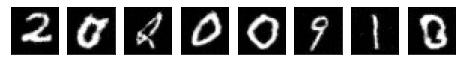

In [ ]:
import datetime
now = datetime.datetime.now(
    datetime.timezone(datetime.timedelta(hours=9)))
year = now.year
month = now.month
day = now.day
today = (str(year) + str(month).zfill(2) + str(day).zfill(2))
today_list = [int(num) for num in today]

c = np.asarray(today_list, dtype=np.int32)
onehot = torch.eye(10)[c].cuda()[:,:,None,None]
z = torch.randn(len(c), 100+10, 1, 1).cuda()
z[:, :10] = onehot
test_img = G(z)
_test_img = (test_img * 256.).clamp(min=0., max=255.).data.cpu().view(len(c), 32, 32).numpy()

fig = plt.figure(figsize=(10, 3))
for i, im in enumerate(_test_img):
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

# 課題
* 条件を固定して線形補間したとき，どのような変化が現れるか確認してください．生成画像AからBへの線形補間は，[0, 1]で線形増加する値$\alpha$を用いて以下の式で表せます．<br>
$$
\hat{z} = (1-\alpha)\cdot z_{A} + \alpha\cdot z_{B}\\
I_{A\rightarrow B} = G(\hat{z})
$$
* データセットをMNISTからCIFAR-10に変えて学習してみてください．

# 参考文献
[1] Mehdi Mirza and Simon Osindero, Conditional Generative Adversarial Nets, arXiv, 2014.\
[2] Alec Radford, Luke Metz and Soumith Chintala, Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, ICLR, 2016.